# Análise de Dados SRAG (2019-2025)
- Alunos:
  - Andrey Gabriel Ferreira Gonçalves
  - Julia Peghini Vilela Borges
  - Jaqueline Nobre da Silva


**Objetivo:** Carregar os dados brutos, consolidar os arquivos anuais e realizar uma análise diagnóstica para identificar a qualidade dos dados (nulos, ignorados, viés de seleção) focando na predição de gravidade (Internação/UTI).

In [1]:
# Célula destinada a armazenar as importações de bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

## Variáveis escolhidas:
- Variáveis *target* (alvo):
  - **UTI:** Foi internado em UTI? (1-Sim, 2-Não, 9-Ignorado).
- **Fatores de Risco / Comorbidades:**
    - CARDIOPATI: Doença Cardiovascular Crônica.
    - HEMATOLOGI: Doença Hematológica Crônica.
    - SIND_DOWN: Síndrome de Down.
    - HEPATICA: Doença Hepática Crônica.
    - ASMA: Asma.
    - DIABETES: Diabetes mellitus.
    - NEUROLOGIC: Doença Neurológica Crônica.
    - PNEUMOPATI: Outra Pneumopatia Crônica.
    - IMUNODEPRE: Imunodeficiência ou Imunodepressão.
    - RENAL: Doença Renal Crônica.
    - OBESIDADE: Obesidade.

- **Variável de controle:**
    - **NU_IDADE_N:** Idade do paciente.

In [2]:
# --- 1. CONFIGURAÇÃO DE ARQUIVOS E DIRETÓRIOS ---

# Caminho para a pasta onde os CSVs estão salvos
path_base = './dados'

# Configuração de Estilo dos Gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Lista exata dos arquivos a serem carregados
arquivos = [
    'INFLUD19-26-06-2025.csv',
    'INFLUD20-26-06-2025.csv',
    'INFLUD21-26-06-2025.csv',
    'INFLUD22-26-06-2025.csv',
    'INFLUD23-26-06-2025.csv',
    'INFLUD24-26-06-2025.csv',
    'INFLUD25-08-12-2025.csv'
]

# Definição das colunas estritamente necessárias
colunas_alvo = [
    'DT_NOTIFIC', # Referência temporal
    'HOSPITAL',   # Alvo 1 (Internação)
    'UTI',        # Alvo 2 (Admissão em UTI)
    'NU_IDADE_N', # Variável de Controle (Valor numérico da idade)
    'TP_IDADE',   # Variável de Controle (Unidade da idade: 1-Dia, 2-Mês, 3-Ano)
    'EVOLUCAO',

    # --- Fatores de Risco / Comorbidades ---
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE'
]

print("Configuração concluída. Preparando para leitura...")

Configuração concluída. Preparando para leitura...


In [3]:
# --- 2. LEITURA E CONCATENAÇÃO DOS DADOS ---

dfs = []
print("--- Iniciando carregamento dos arquivos ---")

for arquivo in arquivos:
    caminho_completo = os.path.join(path_base, arquivo)

    if os.path.exists(caminho_completo):
        try:
            # Utilizando engine='python' e on_bad_lines='skip' para robustez
            df_temp = pd.read_csv(
                caminho_completo,
                sep=';',
                encoding='ISO-8859-1',
                engine='python',
                on_bad_lines='skip',
                usecols=lambda c: c in colunas_alvo
            )

            # Feedback visual do carregamento
            print(f"[OK] {arquivo}: Carregado com {df_temp.shape[0]} linhas.")
            dfs.append(df_temp)

        except Exception as e:
            print(f"[ERRO] Falha ao ler {arquivo}: {e}")
    else:
        print(f"[AVISO] Arquivo não encontrado no caminho: {caminho_completo}")

# Unificação dos DataFrames
if dfs:
    df_final = pd.concat(dfs, ignore_index=True)
    print(f"\n--- SUCESSO ---")
    print(f"Total de pacientes carregados: {df_final.shape[0]}")
else:
    df_final = pd.DataFrame() # Cria vazio para evitar erro
    print("\n[CRÍTICO] Nenhum dado foi carregado. Verifique o caminho da pasta './dados'.")

--- Iniciando carregamento dos arquivos ---
[OK] INFLUD19-26-06-2025.csv: Carregado com 48961 linhas.
[OK] INFLUD20-26-06-2025.csv: Carregado com 1206920 linhas.
[OK] INFLUD21-26-06-2025.csv: Carregado com 1745672 linhas.
[OK] INFLUD22-26-06-2025.csv: Carregado com 560577 linhas.
[OK] INFLUD23-26-06-2025.csv: Carregado com 279453 linhas.
[OK] INFLUD24-26-06-2025.csv: Carregado com 267984 linhas.
[OK] INFLUD25-08-12-2025.csv: Carregado com 314190 linhas.

--- SUCESSO ---
Total de pacientes carregados: 4423757


In [4]:
# --- 3. PRÉ-PROCESSAMENTO E DEFINIÇÃO DO TARGET (UTI) ---

if not df_final.empty:
    print("--- 3.1 Otimização e Conversão de Tipos ---")
    # Colunas que devem ser numéricas
    cols_numericas = ['HOSPITAL', 'UTI', 'NU_IDADE_N', 'TP_IDADE']
    
    # Conversão otimizada e tratamento de erros
    for col in cols_numericas:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
    
    # Otimização de memória (Downcasting) - Importante para 4M+ linhas
    # Converte float64 para float32 ou int onde possível
    for col in df_final.select_dtypes(include=['float', 'int']).columns:
        df_final[col] = pd.to_numeric(df_final[col], downcast='integer')
        
    print("Tipagem corrigida e memória otimizada.")

    # --- 3.2 FILTRAGEM DE ESCOPO ---
    total_geral = len(df_final)
    # Filtrar apenas Hospitalizados (HOSPITAL == 1)
    df_filtrado = df_final[(df_final['HOSPITAL'] == 1) & ((df_final['EVOLUCAO'] == 1))].copy()
    
    print(f"\n--- 3.2 Filtragem de Pacientes ---")
    print(f"Total de Notificações: {total_geral:,.0f}")
    print(f"Pacientes Hospitalizados que tiveram alta ao final do tratamento (Escopo): {len(df_filtrado):,.0f} ({(len(df_filtrado)/total_geral):.1%})")

    # --- 3.3 DEFINIÇÃO DO TARGET ---
    # Analisar como a variável UTI vem preenchida originalmente
    print("\n--- 3.3 Definição do Target (ALVO_GRAVIDADE) ---")
    print("Distribuição original da coluna 'UTI' (1=Sim, 2=Não, 9=Ignorado, NaN=Vazio):")
    print(df_filtrado['UTI'].value_counts(dropna=False).sort_index())

    # Criação do Target Binário:
    # 1 -> 1 (UTI)
    # Qualquer outra coisa (2, 9, NaN) -> 0 (Não UTI/Enfermaria)
    df_filtrado['ALVO_GRAVIDADE'] = np.where(df_filtrado['UTI'] == 1, 1, 0)
    
    print(f"\nTarget criado. Distribuição final:")
    print(df_filtrado['ALVO_GRAVIDADE'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

else:
    print("DataFrame vazio. Verifique o carregamento.")

--- 3.1 Otimização e Conversão de Tipos ---
Tipagem corrigida e memória otimizada.

--- 3.2 Filtragem de Pacientes ---
Total de Notificações: 4,423,757
Pacientes Hospitalizados que tiveram alta ao final do tratamento (Escopo): 2,900,038 (65.6%)

--- 3.3 Definição do Target (ALVO_GRAVIDADE) ---
Distribuição original da coluna 'UTI' (1=Sim, 2=Não, 9=Ignorado, NaN=Vazio):
UTI
1.0     644858
2.0    1968213
9.0      45743
NaN     241224
Name: count, dtype: int64

Target criado. Distribuição final:
ALVO_GRAVIDADE
0    77.76%
1    22.24%
Name: proportion, dtype: object


In [5]:
df_final[(df_final['UTI'] == 1) & (df_final['EVOLUCAO'].notna())]

,DT_NOTIFIC,NU_IDADE_N,TP_IDADE,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,HOSPITAL,UTI,EVOLUCAO
1,2019-01-03,7,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,2019-01-10,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
6,2019-01-08,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
8,2019-01-03,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
12,2019-01-04,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423509,2025-12-03,33,3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
4423522,2025-06-20,69,3,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
4423591,2025-11-20,78,3,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0
4423605,2025-07-29,20,3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0


In [6]:
df_final[(df_final['EVOLUCAO'] == 2) & (df_final['UTI'] == 1)]

,DT_NOTIFIC,NU_IDADE_N,TP_IDADE,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,HOSPITAL,UTI,EVOLUCAO
20,2019-01-07,25,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0
35,2019-01-16,85,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0
40,2019-01-18,57,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0
41,2019-01-08,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0
44,2019-01-15,38,3,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423204,2025-12-05,35,3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
4423355,2025-12-04,73,3,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0
4423439,2025-10-19,84,3,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0
4423462,2025-12-03,13,3,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0


In [7]:
# --- 4. ANÁLISE DE SAÚDE DOS DADOS (Data Quality) ---

if not df_filtrado.empty:
    # Como filtramos a base no passo anterior, df_analise é o próprio df_filtrado
    df_analise = df_filtrado

    print("=== 4.1 Qualidade das Variáveis Explicativas (Comorbidades) ===")
    
    comorbidades = [
        'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
        'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
        'RENAL', 'OBESIDADE'
    ]

    # Construção de um Relatório de Qualidade Tabular
    dados_qualidade = []
    total = len(df_analise)

    for col in comorbidades:
        counts = df_analise[col].value_counts(dropna=False)
        
        nulos = counts.get(np.nan, 0)
        ignorados = counts.get(9, 0)  # Código 9 = Ignorado
        sim = counts.get(1, 0)
        nao = counts.get(2, 0)
        
        # Qualidade: O quanto a variável é 'confiável' (Preenchida com Sim ou Não)
        preenchimento_valido = sim + nao
        ruido = nulos + ignorados

        dados_qualidade.append({
            'Variável': col,
            '% Sim (1)': (sim / total) * 100,
            '% Não (2)': (nao / total) * 100,
            '% Ignorado (9)': (ignorados / total) * 100,
            '% Nulo (NaN)': (nulos / total) * 100,
            '% Ruído Total': (ruido / total) * 100
        })

    df_qualidade = pd.DataFrame(dados_qualidade).set_index('Variável')
    df_qualidade = df_qualidade.sort_values('% Ruído Total', ascending=False)

    # Exibição formatada
    print("Tabela de Integridade das Comorbidades (Ordenada por Ruído):")
    pd.options.display.float_format = '{:.2f}%'.format
    display(df_qualidade)
    pd.options.display.float_format = None

    print("\n=== 4.2 Correlação Preliminar: Idade vs Target ===")
    corr_idade = df_analise['NU_IDADE_N'].corr(df_analise['ALVO_GRAVIDADE'])
    print(f"Correlação de Pearson (Idade <-> Admissão UTI): {corr_idade:.4f}")
    if corr_idade > 0:
        print("-> Correlação Positiva: Quanto maior a idade, maior a chance de UTI.")
    else:
        print("-> Correlação Negativa/Nula.")

else:
    print("DataFrame vazio.")

=== 4.1 Qualidade das Variáveis Explicativas (Comorbidades) ===
Tabela de Integridade das Comorbidades (Ordenada por Ruído):


,% Sim (1),% Não (2),% Ignorado (9),% Nulo (NaN),% Ruído Total
Variável,,,,,
HEPATICA,0.59%,32.00%,0.64%,66.77%,67.41%
SIND_DOWN,0.45%,32.26%,0.59%,66.70%,67.29%
HEMATOLOGI,0.76%,32.00%,0.64%,66.60%,67.25%
RENAL,2.43%,30.68%,0.61%,66.28%,66.89%
IMUNODEPRE,2.29%,30.83%,0.64%,66.24%,66.88%
OBESIDADE,4.77%,28.79%,0.81%,65.63%,66.44%
NEUROLOGIC,3.71%,29.89%,0.60%,65.80%,66.41%
PNEUMOPATI,3.96%,29.66%,0.62%,65.77%,66.39%
ASMA,4.94%,29.07%,0.58%,65.41%,65.99%



=== 4.2 Correlação Preliminar: Idade vs Target ===
Correlação de Pearson (Idade <-> Admissão UTI): 0.0001
-> Correlação Positiva: Quanto maior a idade, maior a chance de UTI.


## Análise inicial da saúde dos dados
- Problemas identificados:
  - Todas as colunas de comorbidade possuem uma alta porcentagem de nulos, sendo 59.14% a menor e 66.77% a maior.

## Investigação de Viés Temporal e Limitações

Além dos nulos, investigamos se há distorções causadas pelo fator **tempo** (anos de pandemia vs. anos normais) e limitações na definição do target.

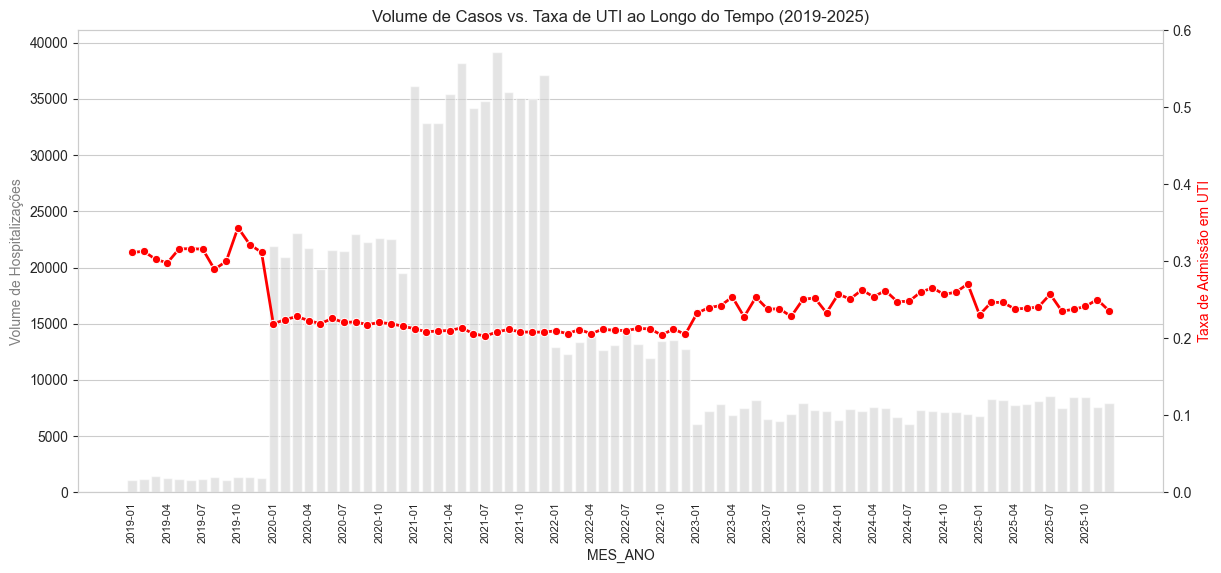

In [8]:
# --- 9.1 ANÁLISE TEMPORAL (Sazonalidade e Pandemia) ---

# Garantir que df_analise é uma cópia independente para evitar SettingWithCopyWarning
df_analise = df_analise.copy()

# Converter Data de Notificação
df_analise['DT_NOTIFIC'] = pd.to_datetime(df_analise['DT_NOTIFIC'], dayfirst=True, errors='coerce')

# Criar coluna de Mês/Ano para agrupamento
df_analise['MES_ANO'] = df_analise['DT_NOTIFIC'].dt.to_period('M')

# Agrupar dados por mês
resumo_temporal = df_analise.groupby('MES_ANO').agg(
    total_casos=('HOSPITAL', 'count'),
    taxa_uti=('ALVO_GRAVIDADE', 'mean')
).reset_index()

# Converter period para timestamp para plotagem
resumo_temporal['MES_ANO_DT'] = resumo_temporal['MES_ANO'].dt.to_timestamp()

# PLOTAGEM
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eixo 1: Volume de Casos (Barras)
sns.barplot(data=resumo_temporal, x='MES_ANO', y='total_casos', color='lightgray', alpha=0.6, ax=ax1)
ax1.set_ylabel('Volume de Hospitalizações', color='gray')
ax1.tick_params(axis='x', rotation=90, labelsize=8)
# Reduzir a quantidade de labels no eixo X para não poluir
for index, label in enumerate(ax1.get_xticklabels()):
    if index % 3 != 0:
        label.set_visible(False)

# Eixo 2: Taxa de UTI (Linha)
ax2 = ax1.twinx()
sns.lineplot(data=resumo_temporal, x=resumo_temporal.index, y='taxa_uti', color='red', marker='o', ax=ax2, linewidth=2)
ax2.set_ylabel('Taxa de Admissão em UTI', color='red')
ax2.set_ylim(0, 0.6) # Escala fixa para visualizar melhor a variação

plt.title('Volume de Casos vs. Taxa de UTI ao Longo do Tempo (2019-2025)')
plt.grid(False)
plt.show()

### Diagnóstico de Problemas Estruturais

1.  **Viés de "Onda" (Temporal):**
    *   O gráfico acima mostra picos claros de volume (Ondas COVID).
    *   Observe a linha vermelha (Taxa UTI): Se ela flutuar drasticamente (ex: cair quando o volume sobe muito), pode indicar **colapso do sistema** (gente precisando de UTI mas não conseguindo vaga), o que "suja" o target.

2.  **O Problema da "Morte Invisível" (Limitação do Target):**
    *   Atualmente definimos `Gravidade = UTI`.
    *   **Risco Crítico:** Pacientes que faleceram na enfermaria ou na emergência *sem* ir para UTI estão sendo classificados como `Target 0` (Não Graves). Isso ensina o modelo errado.
    *   **Recomendação:** Futuramente, incluir a coluna `EVOLUCAO` (Alta/Óbito) na carga de dados para criar um target composto (`UTI == 1` OU `EVOLUCAO == Óbito`).

## Tratamento de Dados (Limpeza e Padronização)

Nesta etapa, aplicaremos as seguintes correções:
1. **Comorbidades:** Devido ao alto número de nulos e ignorados (código 9), assumiremos a premissa conservadora: **Se não marcado como Sim (1), consideramos Não (0)**. Isso permite utilizar os dados para modelagem, transformando as variáveis em binárias.
2. **Idade:** Filtragem de valores inconsistentes (menores que 0 ou maiores que 120 anos) e padronização para anos.
3. **Tipagem:** Garantia de tipos inteiros para variáveis categóricas.

In [9]:
# --- 5. TRATAMENTO DE DADOS ---

# 5.1 Tratamento de Comorbidades
# Mapeamento: 1 -> 1 (Sim), {2, 9, NaN} -> 0 (Não)
cols_comorbidades = [
    'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
    'RENAL', 'OBESIDADE'
]

for col in cols_comorbidades:
    # Preenche nulos com 0, substitui 2 e 9 por 0, mantém 1 como 1
    df_analise[col] = df_analise[col].fillna(0).replace({2: 0, 9: 0}).astype(int)

print("Comorbidades binarias (0/1) processadas.")

# 5.2 Tratamento de Idade
# Padronizar tudo para ANOS (TP_IDADE: 1=Dia, 2=Mês, 3=Ano)
# Para simplificar, se TP_IDADE for 1 ou 2 (bebês), idade em anos é 0.
df_analise.loc[df_analise['TP_IDADE'].isin([1, 2]), 'NU_IDADE_N'] = 0

# Remover inconsistências (Idade negativa ou > 120)
df_analise_filtrado = df_analise[(df_analise['NU_IDADE_N'] >= 18) & (df_analise['NU_IDADE_N'] <= 120)]

print(f"Base após limpeza de idade: {len(df_analise_filtrado)} registros.")

# Verificação final de nulos nas colunas de interesse
print("\nNulos restantes nas colunas-chave:")
print(df_analise_filtrado[cols_comorbidades + ['NU_IDADE_N', 'ALVO_GRAVIDADE']].isnull().sum())

Comorbidades binarias (0/1) processadas.
Base após limpeza de idade: 2109536 registros.

Nulos restantes nas colunas-chave:
CARDIOPATI        0
HEMATOLOGI        0
SIND_DOWN         0
HEPATICA          0
ASMA              0
DIABETES          0
NEUROLOGIC        0
PNEUMOPATI        0
IMUNODEPRE        0
RENAL             0
OBESIDADE         0
NU_IDADE_N        0
ALVO_GRAVIDADE    0
dtype: int64


## Estatísticas Descritivas
Análise da tendência central e dispersão dos dados tratados.

In [10]:
# Estatísticas da Idade (Geral e por Grupo UTI)
print("--- Estatísticas Descritivas: IDADE ---")
# Melhorando a visualização de números grandes e decimais
pd.options.display.float_format = '{:,.2f}'.format
print(df_analise_filtrado['NU_IDADE_N'].describe())
pd.options.display.float_format = None # Resetar para o padrão do pandas

print("\n--- Idade Média por Desfecho (UTI) ---")
print(df_analise_filtrado.groupby('ALVO_GRAVIDADE')['NU_IDADE_N'].agg(['mean', 'median', 'std', 'min', 'max']))

print("\n--- Frequência das Comorbidades (Após Tratamento) ---")
print(df_analise_filtrado[cols_comorbidades].sum().sort_values(ascending=False))

--- Estatísticas Descritivas: IDADE ---
count   2,109,536.00
mean           58.02
std            18.28
min            18.00
25%            44.00
50%            58.00
75%            72.00
max           120.00
Name: NU_IDADE_N, dtype: float64

--- Idade Média por Desfecho (UTI) ---
                     mean  median        std  min  max
ALVO_GRAVIDADE                                        
0               57.888438    58.0  18.375842   18  120
1               58.471028    59.0  17.941260   18  118

--- Frequência das Comorbidades (Após Tratamento) ---
CARDIOPATI    640359
DIABETES      429971
OBESIDADE     135612
PNEUMOPATI    102276
NEUROLOGIC     82272
ASMA           75392
RENAL          66766
IMUNODEPRE     57184
HEMATOLOGI     16003
HEPATICA       15543
SIND_DOWN       5266
dtype: int64


## Análise Visual e Gráfica
Visualização da distribuição de idade e impacto das comorbidades na admissão em UTI.

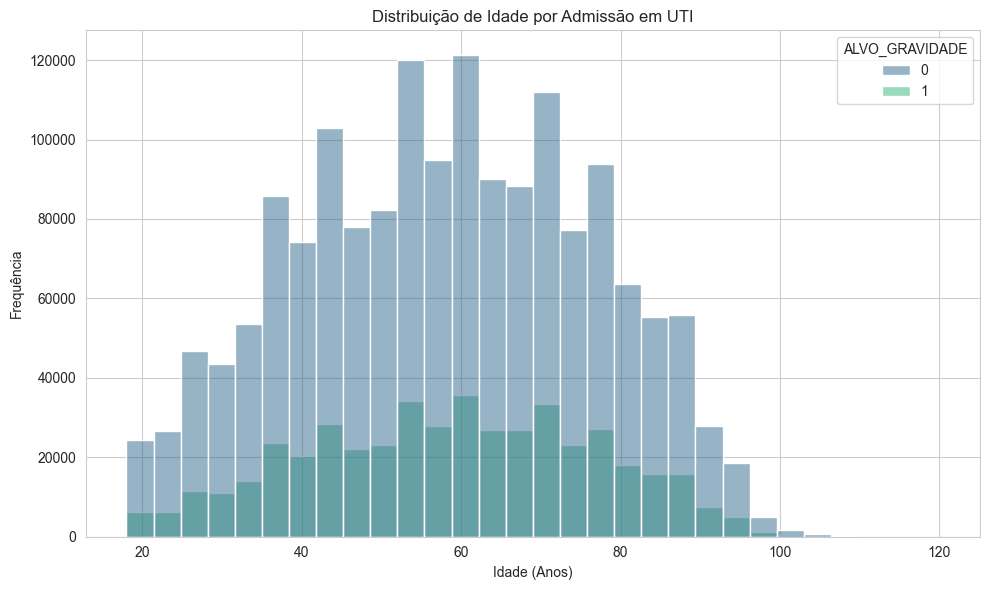

In [11]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_analise_filtrado,
    x='NU_IDADE_N',
    hue='ALVO_GRAVIDADE',
    bins=30,
    palette='viridis'
)

plt.title('Distribuição de Idade por Admissão em UTI')
plt.xlabel('Idade (Anos)')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


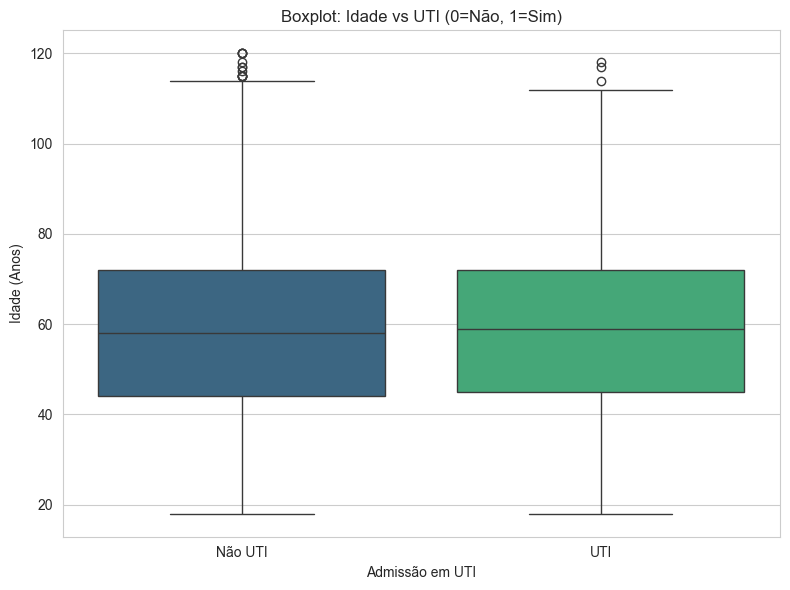

In [12]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='ALVO_GRAVIDADE',
    y='NU_IDADE_N',
    hue='ALVO_GRAVIDADE',
    data=df_analise_filtrado,
    palette='viridis',
    legend=False
)

plt.title('Boxplot: Idade vs UTI (0=Não, 1=Sim)')
plt.xlabel('Admissão em UTI')
plt.ylabel('Idade (Anos)')
plt.xticks([0, 1], ['Não UTI', 'UTI'])

plt.tight_layout()
plt.show()

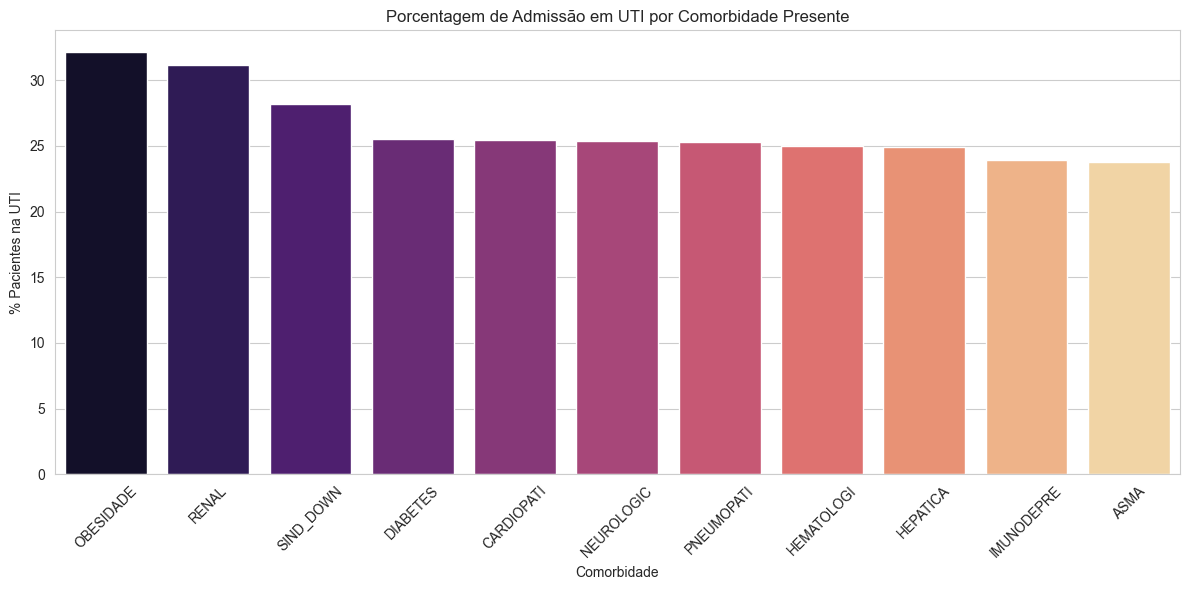

In [13]:
# Calculando % de UTI para quem tem cada comorbidade
risco_comorbidade = []

for col in cols_comorbidades:
    pacientes_com_doenca = df_analise_filtrado[df_analise_filtrado[col] == 1]
    if len(pacientes_com_doenca) > 0:
        taxa_uti = pacientes_com_doenca['ALVO_GRAVIDADE'].mean() * 100
        risco_comorbidade.append({
            'Comorbidade': col,
            '% UTI': taxa_uti
        })

df_risco = (
    pd.DataFrame(risco_comorbidade)
    .sort_values('% UTI', ascending=False)
)

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Comorbidade',
    y='% UTI',
    hue='Comorbidade',
    data=df_risco,
    palette='magma',
    legend=False
)

plt.title('Porcentagem de Admissão em UTI por Comorbidade Presente')
plt.ylabel('% Pacientes na UTI')
plt.xlabel('Comorbidade')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Reflexões e Próximos Passos

**Observações:**
- A distribuição de idade mostra que pacientes mais idosos têm maior tendência a serem admitidos na UTI.
- Algumas comorbidades (como OBESIDADE e RENAL) parecem apresentar taxas proporcionalmente maiores de admissão em UTI em relação a outras, o que sugere alto poder preditivo.
- O tratamento dos nulos (assumindo 0) permitiu recuperar a base completa, mas introduz um viés conservador.

**Próximos Passos:**
- Testar modelos de Machine Learning (Regressão Logística, Random Forest) usando 'ALVO_GRAVIDADE' como target.
- Avaliar balanceamento de classes (SMOTE se necessário, embora a proporção ~30% seja aceitável).

## 6. Modelagem Preditiva

Nesta etapa, realizaremos a engenharia de features, preparação dos dados e treinamento de um modelo de **Regressão Logística** para prever a admissão em UTI.

**Etapas:**
1. **Feature Engineering:** Seleção de variáveis e padronização da idade.
2. **Divisão Treino/Teste:** Separação de 70% para treino e 30% para teste.
3. **Treinamento:** Ajuste do modelo de Regressão Logística.
4. **Avaliação:** Métricas de desempenho (Acurácia, Matriz de Confusão).

In [14]:
# --- 6.1 FEATURE ENGINEERING ---
# Seleção das Features (X) e Target (y)
features = ['NU_IDADE_N'] + cols_comorbidades
X = df_analise_filtrado[features].copy()
y = df_analise_filtrado['ALVO_GRAVIDADE']

# Verificação de segurança: Substituir NaNs/Infs por 0 antes de escalar
X = X.fillna(0)
# Padronização de TODAS as variáveis
# Para Regressão Logística com solver lbfgs em grandes datasets, é crucial que todas as features tenham a mesma escala
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("Features padronizadas e verificadas.")
print(f"Shape de X: {X.shape}")

# --- 6.2 DIVISÃO TREINO/TESTE ---
# Escolha 70/30: Padrão robusto para grandes volumes de dados (>4M registros),
# garantindo que o teste tenha tamanho suficiente para significância estatística.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Tamanho do Treino: {X_train.shape[0]} registros")
print(f"Tamanho do Teste: {X_test.shape[0]} registros")

Features padronizadas e verificadas.
Shape de X: (2109536, 12)
Tamanho do Treino: 1476675 registros
Tamanho do Teste: 632861 registros


In [15]:
# Quantidades brutas e suas porcentagens do total de cada classe nos dois conjuntos
print("\nDistribuição das Classes no Treino:")
train_counts = y_train.value_counts()
print(pd.DataFrame({
    'Quantidade': train_counts,
    'Porcentagem': (train_counts / len(y_train) * 100).round(2).astype(str) + '%'
}))

print("\nDistribuição das Classes no Teste:")
test_counts = y_test.value_counts()
print(pd.DataFrame({
    'Quantidade': test_counts,
    'Porcentagem': (test_counts / len(y_test) * 100).round(2).astype(str) + '%'
}))


Distribuição das Classes no Treino:
                Quantidade Porcentagem
ALVO_GRAVIDADE                        
0                  1151106      77.95%
1                   325569      22.05%

Distribuição das Classes no Teste:
                Quantidade Porcentagem
ALVO_GRAVIDADE                        
0                   493332      77.95%
1                   139529      22.05%


Treinando modelo (solver='saga')... (pode demorar alguns instantes)


/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    493332
           1       0.25      0.00      0.00    139529

    accuracy                           0.78    632861
   macro avg       0.51      0.50      0.44    632861
weighted avg       0.66      0.78      0.68    632861

Acurácia: 0.7795
=== MATRIZ DE CONFUSÃO ===
[[493271     61]
 [139509     20]]


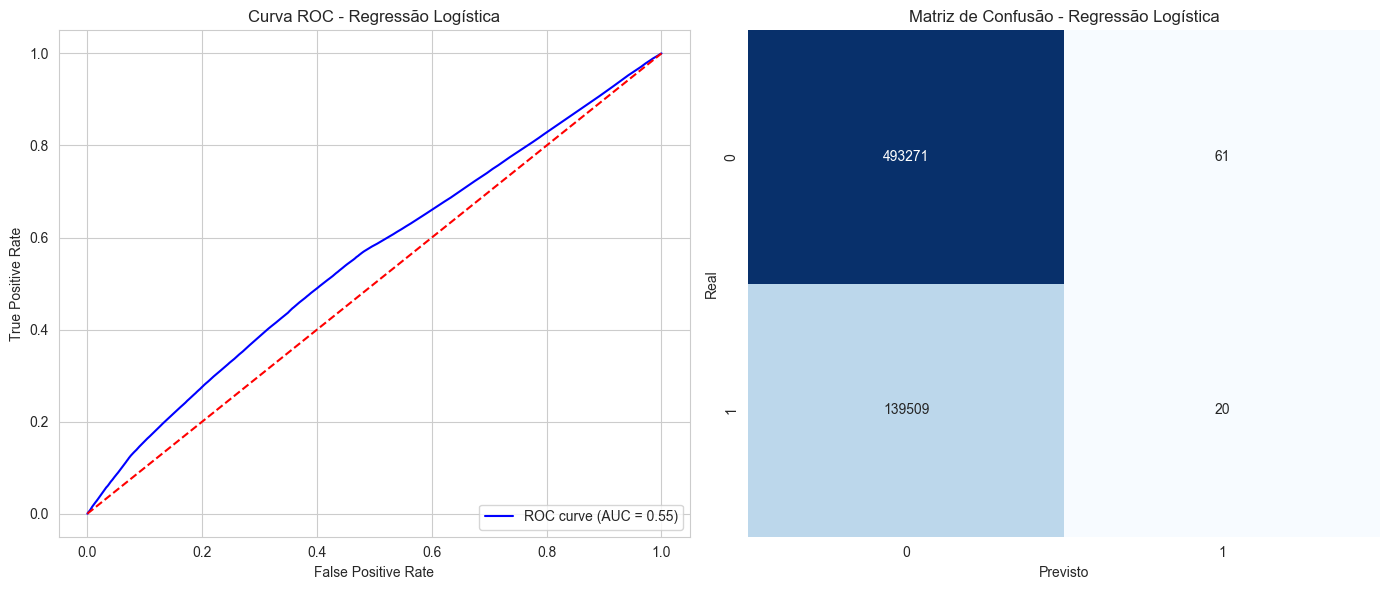

In [23]:
# --- 6.3 TREINAMENTO E AVALIAÇÃO DO MODELO (Regressão Logística) ---
# Instanciação do Modelo
# Alterado para solver='saga' que é mais robusto para grandes datasets e menos propenso a overflows numéricos
# Reduzida max_iter para teste inicial, mas saga geralmente converge bem.
model = LogisticRegression(random_state=42, max_iter=100, solver='saga', n_jobs=-1)
print("Treinando modelo (solver='saga')... (pode demorar alguns instantes)")
model.fit(X_train, y_train)

# Predições
y_pred = model.predict(X_test)

# --- 6.4 MÉTRICAS ---
print("=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print("=== MATRIZ DE CONFUSÃO ===")
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# Visualização
plt.figure(figsize=(14, 6))

# Curva ROC
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc='lower right')

# Matriz de Confusão
plt.subplot(1, 2, 2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística')

plt.tight_layout()
plt.show()

### Análise Preliminar do Modelo
- Apesar do modelo apresentar uma acurácia de 77% o resultado não é satisfatório levando em consideração o baixíssimo recall da classe UTI (0%)
- Além do recall baixo, a matriz de confusão aponta uma quantidade muito grande de falsos negativos na classe UTI, o que mostra que o modelo ficou enviezado por conta da maioria dos casos serem de pessoas que não foram para a UTI
- A falta de uso de técnicas de balanceamento nos dados afetou negativamente o resultado esperado pelo modelo 

### **Próximos passos**
- Testar um modelo de árvore de decisão para tentar lidar melhor com a não linearidade dos dados
- Aplicar técnicas de balanceamento para deixar a quantidade de dados entre as duas classes mais próxima
- Aplicar PCA para diminuir a dimensionalidade dos dados (Levando em consideração que 12 variáveis estão sendo utilizadas no modelo)

In [24]:
# --- 7. ESTRATÉGIA DE MELHORIA: BALANCEAMENTO E NOVOS MODELOS ---

# 7.1 Undersampling Manual
print("--- 7.1 Aplicando Undersampling Manual ---")

# Separar as classes usando o DataFrame original filtrado
df_majority = df_analise_filtrado[df_analise_filtrado['ALVO_GRAVIDADE'] == 0]
df_minority = df_analise_filtrado[df_analise_filtrado['ALVO_GRAVIDADE'] == 1]

# Determinar o número de amostras na classe minoritária
minority_count = len(df_minority)
print(f"Classe Minoritária (UTI=1): {minority_count:,}")
print(f"Classe Majoritária (UTI=0) Original: {len(df_majority):,}")

# Subamostrar a classe majoritária
df_majority_undersampled = df_majority.sample(n=minority_count, random_state=42)

# Concatenar e embaralhar
df_balanced = pd.concat([df_majority_undersampled, df_minority]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total de registros após balanceamento: {len(df_balanced):,}")
print(df_balanced['ALVO_GRAVIDADE'].value_counts(normalize=True))

--- 7.1 Aplicando Undersampling Manual ---
Classe Minoritária (UTI=1): 465,098
Classe Majoritária (UTI=0) Original: 1,644,438
Total de registros após balanceamento: 930,196
ALVO_GRAVIDADE
0    0.5
1    0.5
Name: proportion, dtype: float64


In [25]:
# --- 7.2 REDUÇÃO DE DIMENSIONALIDADE (PCA) ---

print("\n--- 7.2 Aplicando PCA ---")

# Preparar X e y do dataset balanceado
# features já foi definido anteriormente como ['NU_IDADE_N'] + cols_comorbidades
X_balanced = df_balanced[features].copy()
y_balanced = df_balanced['ALVO_GRAVIDADE']

# Padronizar novamente (CRUCIAL para PCA)
scaler_pca = StandardScaler()
X_balanced_scaled = scaler_pca.fit_transform(X_balanced)

# Aplicar PCA
# Vamos manter 95% da variância explicada para ver quantas componentes são necessárias
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_balanced_scaled)

print(f"Número original de features: {X_balanced.shape[1]}")
print(f"Número de componentes para 95% de variância: {X_pca.shape[1]}")
print(f"Variância explicada por componente: {pca.explained_variance_ratio_}")

# Criar DataFrame com as componentes principais (opcional, para visualização)
cols_pca = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=cols_pca)


--- 7.2 Aplicando PCA ---
Número original de features: 12
Número de componentes para 95% de variância: 12
Variância explicada por componente: [0.13836756 0.09891825 0.09225553 0.08742977 0.08353727 0.07974975
 0.07868599 0.07772163 0.07650596 0.07348975 0.0610023  0.05233624]


/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T



--- 7.3 Treinando Árvore de Decisão ---
=== RELATÓRIO DE CLASSIFICAÇÃO (Árvore + PCA + Balanceado) ===
              precision    recall  f1-score   support

           0       0.54      0.59      0.57    139530
           1       0.55      0.50      0.52    139529

    accuracy                           0.55    279059
   macro avg       0.55      0.55      0.54    279059
weighted avg       0.55      0.55      0.54    279059

Acurácia: 0.5454


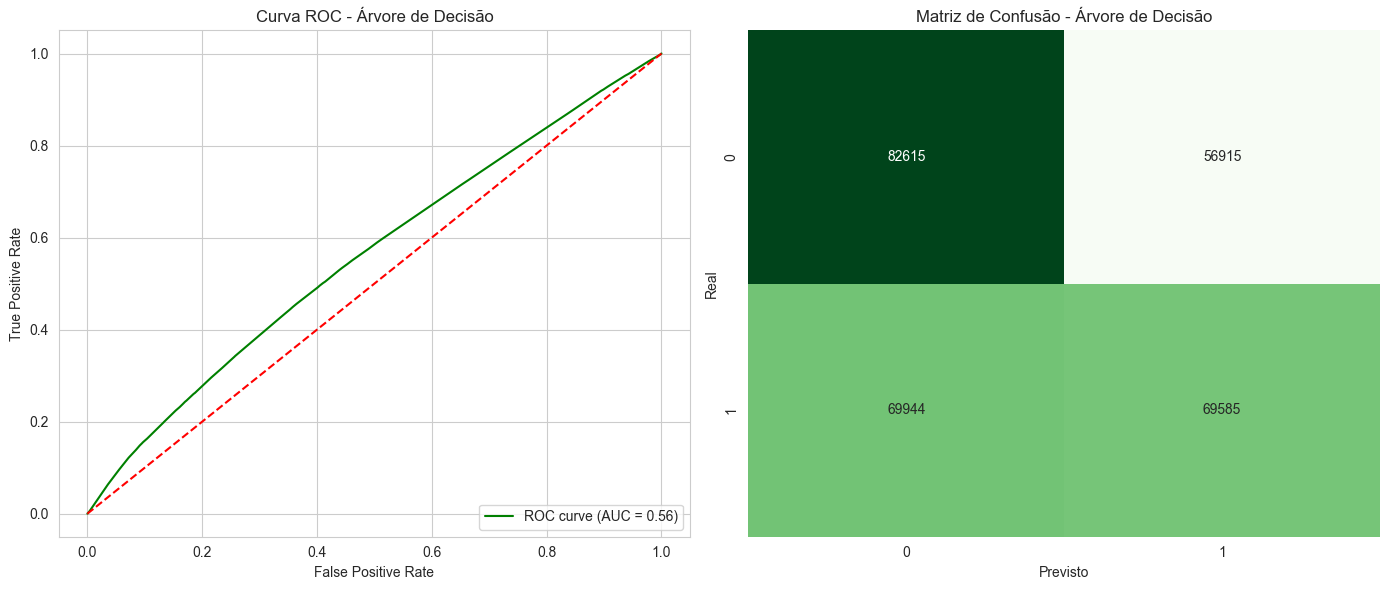

In [26]:
# --- 7.3 TREINAMENTO: ÁRVORE DE DECISÃO COM PCA ---

print("\n--- 7.3 Treinando Árvore de Decisão ---")

# Divisão Treino/Teste nos dados balanceados e reduzidos
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    df_pca, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# Modelo de Árvore
# max_depth=10 é um chute inicial para evitar overfitting, pode ser ajustado
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced') 
dt_model.fit(X_train_pca, y_train_pca)

# Predições
y_pred_dt = dt_model.predict(X_test_pca)

# Métricas
print("=== RELATÓRIO DE CLASSIFICAÇÃO (Árvore + PCA + Balanceado) ===")
print(classification_report(y_test_pca, y_pred_dt))
print(f"Acurácia: {accuracy_score(y_test_pca, y_pred_dt):.4f}")

# Visualização
plt.figure(figsize=(14, 6))

# Cursa ROC
y_prob_dt = dt_model.predict_proba(X_test_pca)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_pca, y_prob_dt)
roc_auc_dt = roc_auc_score(y_test_pca, y_prob_dt)
plt.subplot(1, 2, 1)
plt.plot(fpr_dt, tpr_dt, color='green', label=f'ROC curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Árvore de Decisão')
plt.legend(loc='lower right')


# Matriz de Confusão
plt.subplot(1, 2, 2)
conf_mat_dt = confusion_matrix(y_test_pca, y_pred_dt)
sns.heatmap(conf_mat_dt, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Árvore de Decisão')

plt.tight_layout()
plt.show()


--- 7.4 Reavaliando Regressão Logística com Dados Balanceados ---
Treinando modelo em dados balanceados... (pode demorar alguns instantes)
=== RELATÓRIO DE CLASSIFICAÇÃO (Regressão Logística + Balanceado) ===
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    139530
           1       0.56      0.45      0.49    139529

    accuracy                           0.54    279059
   macro avg       0.55      0.54      0.54    279059
weighted avg       0.55      0.54      0.54    279059

Acurácia: 0.5447


/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/USUARIO1/.pyenv/versions/3.12.10/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


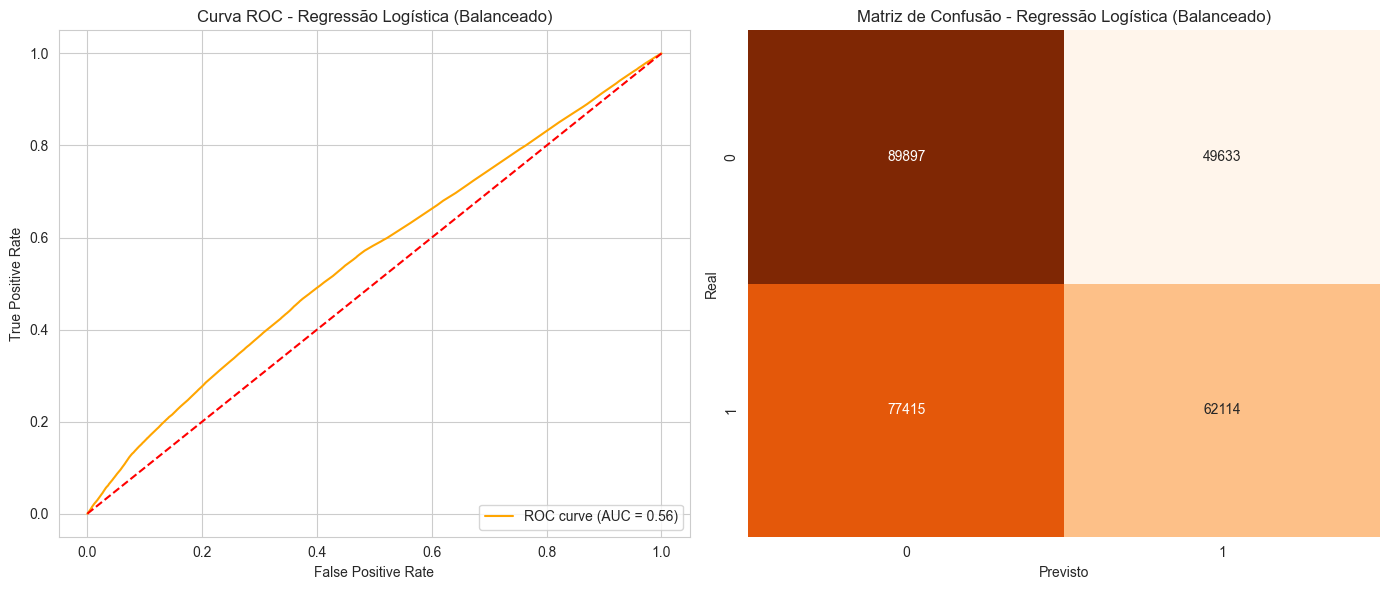

In [27]:
# 7.4 Reavalição da Regressão Logística
print("\n--- 7.4 Reavaliando Regressão Logística com Dados Balanceados ---")
# Preparar X e y do dataset balanceado
# features já foi definido anteriormente como ['NU_IDADE_N'] + cols_comorbidades
X_balanced = df_balanced[features].copy()
y_balanced = df_balanced['ALVO_GRAVIDADE']

# Padronizar novamente (CRUCIAL para PCA)
scaler_balanced = StandardScaler()
X_balanced_scaled = scaler_balanced.fit_transform(X_balanced)
# Divisão Treino/Teste
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced_scaled, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

# Treinamento do Modelo
model_balanced = LogisticRegression(random_state=42, max_iter=100, solver='saga', n_jobs=-1)
print("Treinando modelo em dados balanceados... (pode demorar alguns instantes)")
model_balanced.fit(X_train_bal, y_train_bal)
# Predições
y_pred_bal = model_balanced.predict(X_test_bal)
# Métricas
print("=== RELATÓRIO DE CLASSIFICAÇÃO (Regressão Logística + Balanceado) ===")
print(classification_report(y_test_bal, y_pred_bal))
print(f"Acurácia: {accuracy_score(y_test_bal, y_pred_bal):.4f}")

# Visualização
plt.figure(figsize=(14, 6))

# Curva ROC
y_prob_bal = model_balanced.predict_proba(X_test_bal)[:, 1]
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test_bal, y_prob_bal)
roc_auc_bal = roc_auc_score(y_test_bal, y_prob_bal)
plt.subplot(1, 2, 1)
plt.plot(fpr_bal, tpr_bal, color='orange', label=f'ROC curve (AUC = {roc_auc_bal:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regressão Logística (Balanceado)')
plt.legend(loc='lower right')

# Matriz de Confusão
conf_mat_bal = confusion_matrix(y_test_bal, y_pred_bal)
plt.subplot(1, 2, 2)
sns.heatmap(conf_mat_bal, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Regressão Logística (Balanceado)')

plt.tight_layout()
plt.show()

--- 8.1 Engenharia de Features ---
Nova feature criada: QTD_COMORBIDADES

--- 8.2 Treinando Random Forest (Ensemble) ---
=== RELATÓRIO DE CLASSIFICAÇÃO (Random Forest) ===
              precision    recall  f1-score   support

           0       0.54      0.60      0.57    139530
           1       0.55      0.49      0.52    139529

    accuracy                           0.54    279059
   macro avg       0.54      0.54      0.54    279059
weighted avg       0.54      0.54      0.54    279059

Acurácia: 0.5443


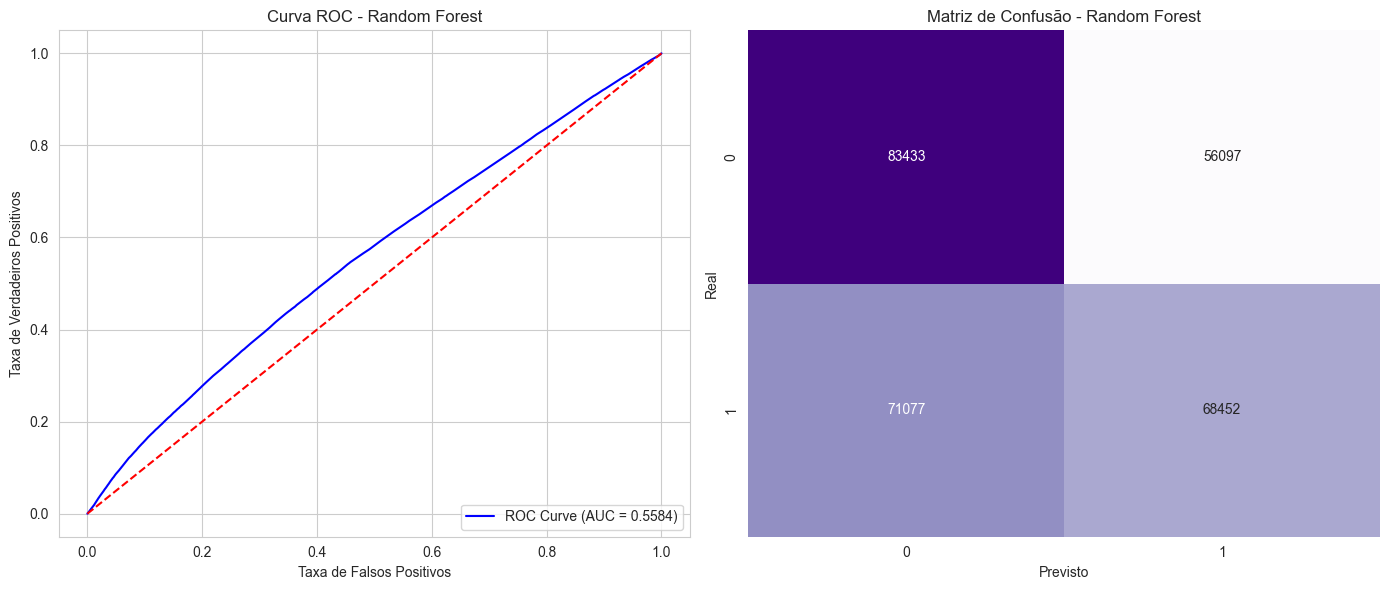

In [28]:
# --- 8. ESTRATÉGIA AVANÇADA: RANDOM FOREST SEM PCA & ENGENHARIA DE FEATURES ---

print("--- 8.1 Engenharia de Features ---")
# Criar uma variável que representa a carga de doenças do paciente
# Isso ajuda o modelo a distinguir quem tem múltiplas condições
df_balanced['QTD_COMORBIDADES'] = df_balanced[cols_comorbidades].sum(axis=1)

# Atualizar lista de features
features_new = ['NU_IDADE_N', 'QTD_COMORBIDADES'] + cols_comorbidades
print("Nova feature criada: QTD_COMORBIDADES")


print("\n--- 8.2 Treinando Random Forest (Ensemble) ---")

# Divisão Treino/Teste na base balanceada
X = df_balanced[features_new]
y = df_balanced['ALVO_GRAVIDADE']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Random Forest é mais robusto que uma única árvore
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train_rf)

# Predições
y_pred_rf = rf_model.predict(X_test_rf)

# --- 8.3 Avaliação ---
print("=== RELATÓRIO DE CLASSIFICAÇÃO (Random Forest) ===")
print(classification_report(y_test_rf, y_pred_rf))
print(f"Acurácia: {accuracy_score(y_test_rf, y_pred_rf):.4f}")

# Visualização
plt.figure(figsize=(14, 6))

# Curva ROC
plt.subplot(1, 2, 1)
y_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_rf, y_prob_rf)
roc_auc = roc_auc_score(y_test_rf, y_prob_rf)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC - Random Forest')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')

# Matriz de Confusão
plt.subplot(1, 2, 2)
conf_mat_rf = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')

plt.tight_layout()
plt.show()

/var/folders/_h/b8prgvks6xndtgnpbnjcxqfh0000gn/T/ipykernel_1763/491149582.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')


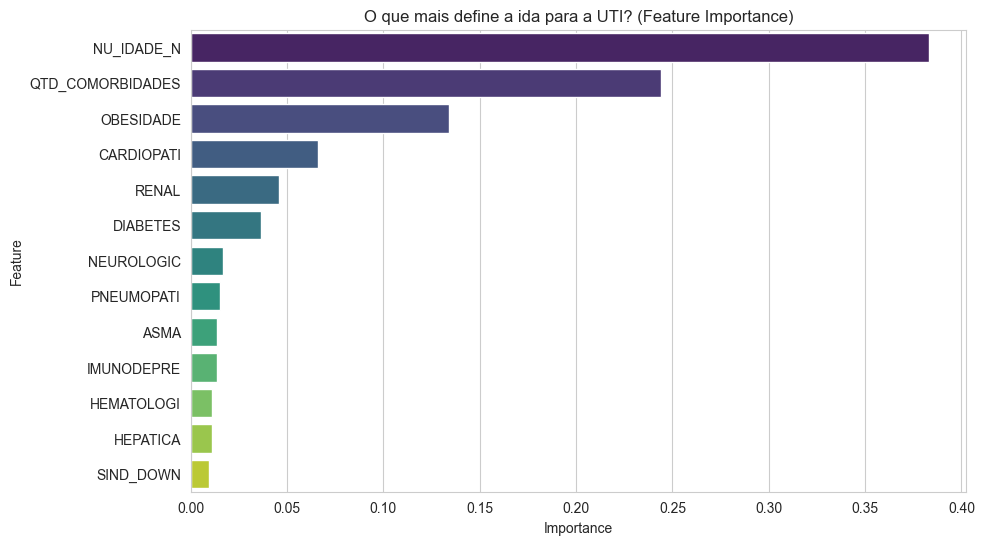

In [29]:
# --- 8.4 Importância das Variáveis ---
# Ver o que o modelo considerou mais importante para decidir UTI vs Não-UTI
importances = pd.DataFrame({
    'Feature': features_new,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('O que mais define a ida para a UTI? (Feature Importance)')
plt.show()

--- 9.1 Treinando Gradient Boosting Classifier ---
=== RELATÓRIO DE CLASSIFICAÇÃO (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.54      0.59      0.56    139530
           1       0.55      0.51      0.53    139529

    accuracy                           0.55    279059
   macro avg       0.55      0.55      0.55    279059
weighted avg       0.55      0.55      0.55    279059

Acurácia: 0.5463
ROC AUC Score: 0.5607


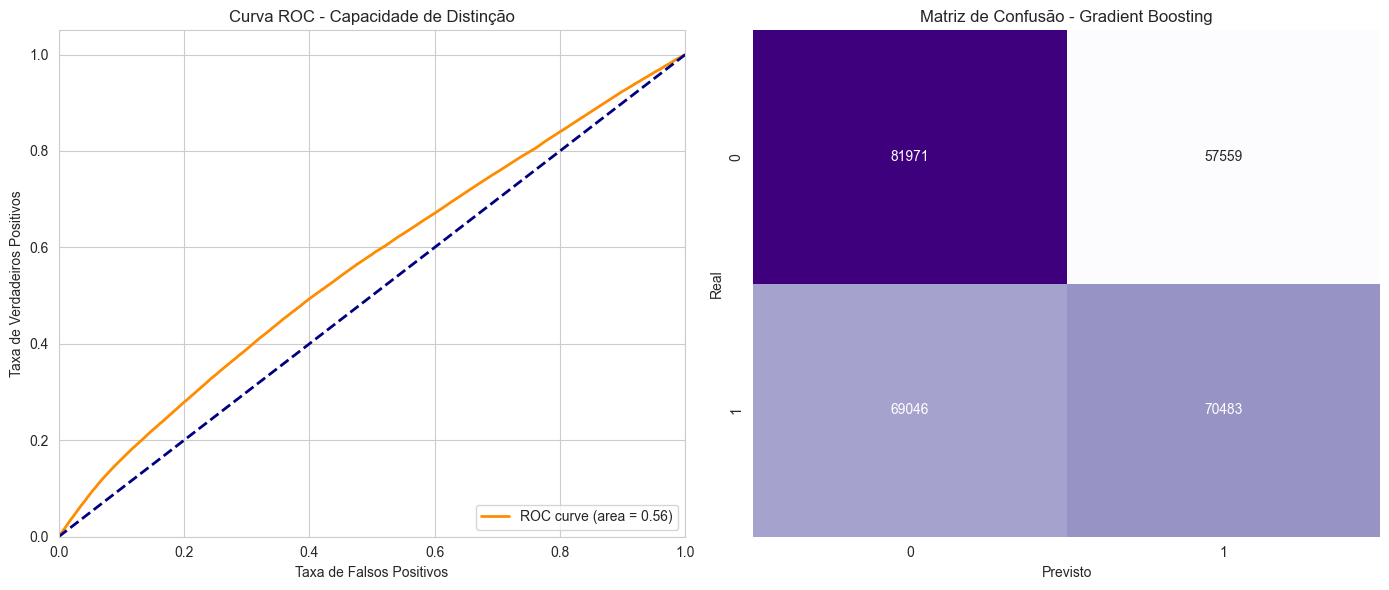

In [30]:
# --- 9. ESTRATÉGIA FINAL: GRADIENT BOOSTING (SKLEARN) ---

print("--- 9.1 Treinando Gradient Boosting Classifier ---")
# O Gradient Boosting constrói árvores sequencialmente para corrigir erros anteriores.
# Geralmente supera Random Forest em dados com fronteiras de decisão complexas.

# Usaremos os mesmos dados de treino/teste balanceados do passo anterior (X_train_rf, etc)
# pois eles já contém a feature 'QTD_COMORBIDADES' e não têm PCA.

gb_model = GradientBoostingClassifier(
    n_estimators=200,      # Mais árvores que o padrão (100)
    learning_rate=0.1,     # Taxa de aprendizado padrão
    max_depth=5,           # Árvores um pouco mais profundas para capturar interações
    random_state=42
)

gb_model.fit(X_train_rf, y_train_rf)

# Predições (Classes e Probabilidades)
y_pred_gb = gb_model.predict(X_test_rf)
y_proba_gb = gb_model.predict_proba(X_test_rf)[:, 1]

# --- 9.2 Avaliação ---
print("=== RELATÓRIO DE CLASSIFICAÇÃO (Gradient Boosting) ===")
print(classification_report(y_test_rf, y_pred_gb))
print(f"Acurácia: {accuracy_score(y_test_rf, y_pred_gb):.4f}")

# Cálculo da Área sob a Curva ROC (AUC)
roc_auc = roc_auc_score(y_test_rf, y_proba_gb)
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- 9.3 Visualizações ---
plt.figure(figsize=(14, 6))

# Plot 1: Curva ROC
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test_rf, y_proba_gb)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Capacidade de Distinção')
plt.legend(loc="lower right")

# Plot 2: Matriz de Confusão
plt.subplot(1, 2, 2)
conf_mat_gb = confusion_matrix(y_test_rf, y_pred_gb)
sns.heatmap(conf_mat_gb, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Gradient Boosting')

plt.tight_layout()
plt.show()

### Análise preliminar dos modelos e da base
- Mesmo após tentar com modelos diferentes e balancear as bases, o ruído gerado pela grande quantidade de nulos e a premissa de tratar vazios e ignorados como não, principalmente porque os vazios eram a grande maioria dos preenchimentos de comorbidades.
- As métricas ficaram abaixo de 70% em todos os modelos e o AUC-ROC foi de somente 0.56 no modelo mais poderoso para lidar com esse tipo de situação que são as árvores de decisão utilizando gradient boosting.

### **Próximos passo**
- Avaliar como podemos melhorar as métricas a partir de uma modelagem mais adequada da base